In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import sys
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold, LeaveOneOut
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, f1_score
import xgboost as xgb
from get_data import *

### Data load

In [2]:
ds, cols_model = get_data_model_v2(k_clusters=6)
ds.info()

Database object created


c:\Users\ivan\Desktop\Coding\corunaRealEstateMarket\bd.py:46: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, self.connection)


Best k for clustering zones: 4
Column n_banos has more than 20% of missing values.
Column n_plazas_garaje has more than 20% of missing values.
<class 'pandas.core.frame.DataFrame'>
Int64Index: 724 entries, 0 to 723
Data columns (total 94 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   zona_cluster                      724 non-null    float64
 1   id                                724 non-null    float64
 2   titulo                            724 non-null    object 
 3   descripcion                       711 non-null    object 
 4   extra_info                        720 non-null    object 
 5   n_habitaciones                    724 non-null    float64
 6   tamano                            724 non-null    float64
 7   precio                            724 non-null    float64
 8   municipio                         724 non-null    object 
 9   n_banos                           724 non-null    floa

In [3]:
x = ds[cols_model].drop('precio', axis=1)
y = ds['precio']

### Model: Linear reg

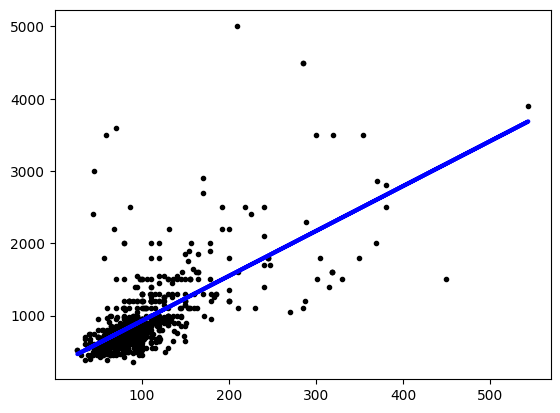

In [69]:
# linear reg with plot
xx = x['tamano'].values.reshape(-1,1)

plt.scatter(xx, y, color='black', marker='.')
model.fit(xx, y)
y_pred = model.predict(xx)
plt.plot(xx, y_pred, color='blue', linewidth=3)

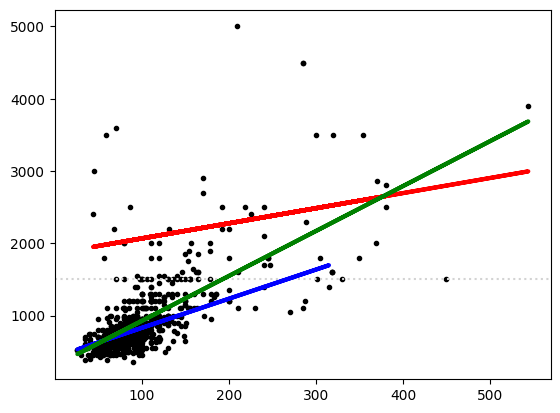

In [88]:
# linear reg with plot
xx = x['tamano'].values.reshape(-1,1)
plt.scatter(xx, y, color='black', marker='.')
boundary = 1500
# plot the boundary gret dotted line
plt.axhline(y=boundary, color='lightgrey', linestyle='dotted')

model = LinearRegression()
xxx = xx[y<boundary]
yyy = y[y<boundary]
model.fit(xxx, yyy)
y_pred = model.predict(xxx)
plt.plot(xxx, y_pred, color='blue', linewidth=3)

model = LinearRegression()
xxx = xx[y>boundary]
yyy = y[y>boundary]
model.fit(xxx, yyy)
y_pred = model.predict(xxx)
plt.plot(xxx, y_pred, color='red', linewidth=3)

model.fit(xx, y)
y_pred = model.predict(xx)
plt.plot(xx, y_pred, color='green', linewidth=3)

### Model: Piecewise linear reg

##### Metodo 1


                    Breakpoint Regression Results                     
No. Observations                      724
No. Model Parameters                    4
Degrees of Freedom                    720
Res. Sum of Squares            1.1488e+08
Total Sum of Squares          2.05672e+08
R Squared                        0.441444
Adjusted R Squared               0.438337
Converged:                           True
                    Estimate      Std Err            t        P>|t|       [0.025       0.975]
----------------------------------------------------------------------------------------------------
const                248.145         41.9       5.9164      5.09e-09        165.8       330.49
alpha1               6.82186        0.409        16.68      4.63e-53       6.0189       7.6248
beta1                -3.1531         1.43      -2.2023             -      -5.9639     -0.34227
breakpoint1          268.407         45.6            -             -        178.8       358.01
-----------------

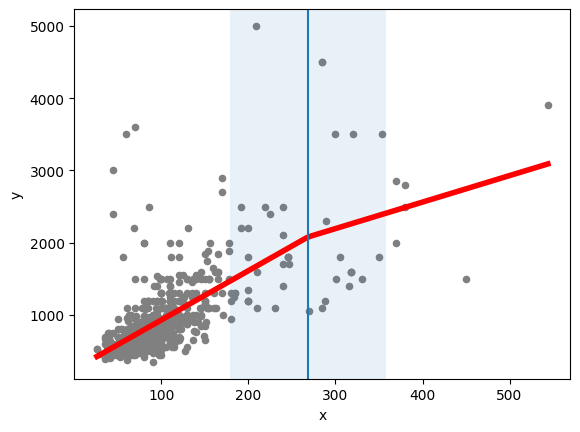

In [6]:
import piecewise_regression
pw_fit = piecewise_regression.Fit(x['tamano'].values, y.values, n_breakpoints=1)
pw_fit.summary()
pw_fit.plot_data(color="grey", s=20)
# Pass in standard matplotlib keywords to control any of the plots
pw_fit.plot_fit(color="red", linewidth=4)
pw_fit.plot_breakpoints()
pw_fit.plot_breakpoint_confidence_intervals()
plt.xlabel("x")
plt.ylabel("y")
plt.show()
plt.close()

##### Metodo 2

Punto de cortes:  3442.7301619334585
Error:  400.0687292443793


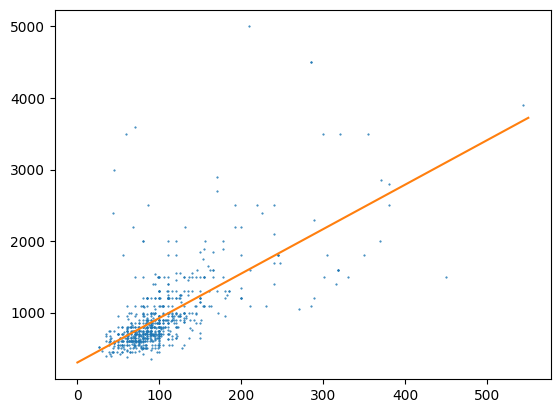

In [64]:
from scipy import optimize

xx = x['tamano'].values

def piecewise_linear(x, x0, y0, k1, k2):
    return np.piecewise(x, [x < x0, x >= x0], [lambda x:k1*x + y0-k1*x0, lambda x:k2*x + y0-k2*x0])

p , e = optimize.curve_fit(piecewise_linear, xx, y)
print('Punto de cortes: ', p[0])

# calculate errors
residuals = y - piecewise_linear(xx, *p)
error = np.sqrt(np.mean(residuals**2))
print('Error: ', error)

xd = np.linspace(0, 550, 2000)
plt.plot(xx, y, ".", markersize=1)
plt.plot(xd, piecewise_linear(xd, *p))
plt.show()

##### Metodo 3: Piecewise Linear Regression with a decision tree

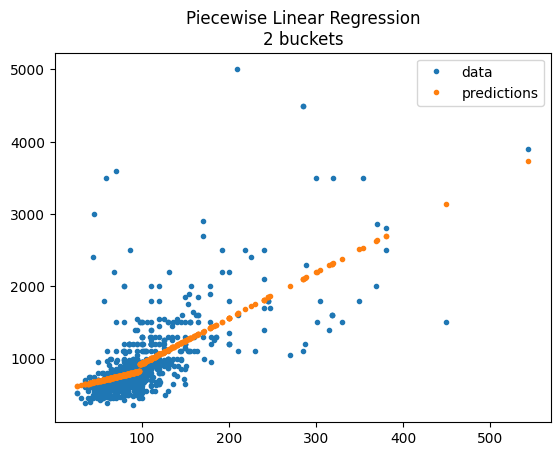

In [86]:
from mlinsights.mlmodel import PiecewiseRegressor
from sklearn.tree import DecisionTreeRegressor

model = PiecewiseRegressor(verbose=True, binner=DecisionTreeRegressor(min_samples_leaf=300), estimator=LinearRegression())
model.fit(xx, y)

pred = model.predict(xx)

fig, ax = plt.subplots(1, 1)
ax.plot(xx[:, 0], y, ".", label='data')
ax.plot(xx[:, 0], pred, ".", label="predictions")
ax.set_title("Piecewise Linear Regression\n2 buckets")
ax.legend();

##### Método 4: Piecewise Linear Regression with a KBinsDiscretizer

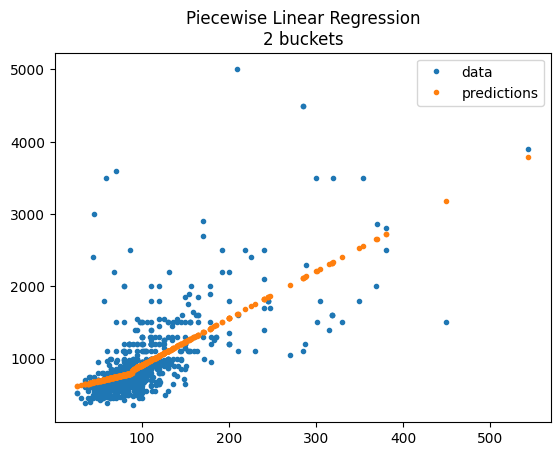

In [87]:
from sklearn.preprocessing import KBinsDiscretizer
model = PiecewiseRegressor(verbose=True, binner=KBinsDiscretizer(n_bins=2), estimator=LinearRegression())
model.fit(xx, y)

fig, ax = plt.subplots(1, 1)
ax.plot(xx[:, 0], y, ".", label='data')
ax.plot(xx[:, 0], model.predict(xx), ".", label="predictions")
ax.set_title("Piecewise Linear Regression\n2 buckets")
ax.legend();